---
<div class="alert alert-block alert-warning">
<h1><span style="color:green"> Under-Graduate Research Internship Program (UGRIP) - 2024 </span><h1>
<h2><span style="color:green"> Lab-02 Part-C: Convolutional Neural Networks (CNNs) </span><h2>
</div>
    
---
    

## Preparing the environment

Before starting make sure the following libraries are installed in the conda environment you created yesterday:

*   numpy
*   matplotlib
*   seaborn
*   tqdm
*   torch
*   torchvision
*   scikit-image

In [1]:
## Standard libraries

import time
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Utils

In [2]:
def set_seed(seed):
    """
    Set the seed for all random number generators.

    Args:
        seed (int): The seed to be used.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

    return None

## Preparing the dataset

## MNIST Data preparation

## Transformations

### Normalize

### Resize

### ToTensor

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Resize((32, 32))
])

### Load MNIST data and apply transformations

In [4]:
# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Explore the dataset

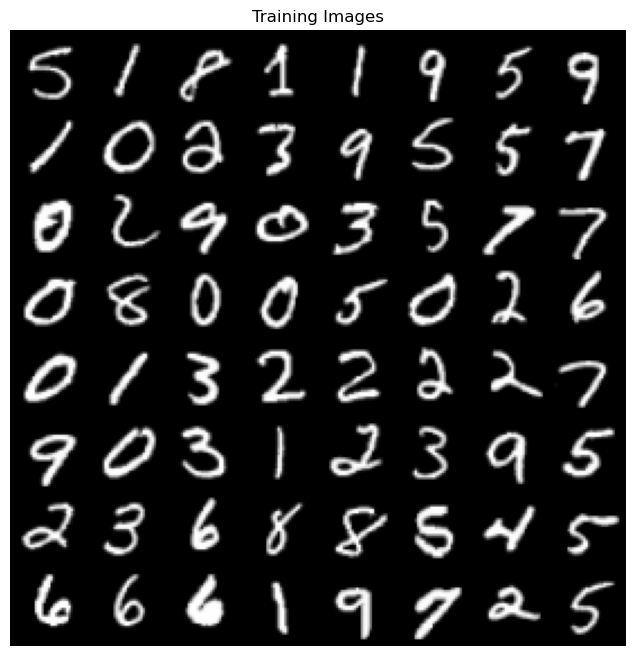

In [5]:
real_batch = next(iter(train_loader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

---
## LeNet -5 network

In this section, we will introduce *LeNet*,
among the first published CNNs
to capture wide attention for its performance on computer vision tasks.
The model was introduced by (and named for) Yann LeCun 
for the purpose of recognizing handwritten digits in images.
At that time LeNet achieved outstanding results
matching the performance of support vector machines (a dominant approach in supervised learning at that time) achieving an error rate of less than 1% per digit.

At a high level, **LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional and two pooling layers; and
(ii) a dense block consisting of three fully connected layers**;
The architecture is summarized in figure below:

![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](https://d2l.ai/_images/lenet.svg)

* Convolutional layers can be created as `nn.Conv2d(N, C, K)`. For input images of size `W×H`, the output feature maps have size `[W−K+1]x[H−K+1]`.  

* Maxpooling is implemented like any other non-linear function (such as ReLU or softmax). For input images of size `W×H`, the output feature maps have size `[W/L]×[H/L]`.  

* A fully connected layer can be created as `nn.Linear(M, N)`.

Architecture:  

(a) a convolutional layer connecting the input image to `6` feature maps with `5×5` convolutions (`K=5`) and followed by ReLU and maxpooling (`L=2`)  

(b) a convolutional layer connecting the `6` input channels to `16` output channels with `5×5` convolutions and followed by ReLU and maxpooling (`L=2`)  

(c) a fully-connected layer connecting `16` feature maps to `120` output units and followed by ReLU  

(d) a fully-connected layer connecting `120` inputs to `84` output units and followed by ReLU  

(e) a final linear layer connecting `84` inputs to `10` linear outputs (one for each of our digits)

First layer  
* input: `(28, 28, 1)`  
* after *padding*: `(32, 32, 1)`
* after convolution(kernel=`5x5`): `(28, 28, 6)` where `28=32-5+1`  
* after ReLU: `(28, 28, 6)`  
* after maxpooling / avgpooling(stride=`2x2`): `(14, 14, 6)` $\Rightarrow$ **OUTPUT**  


Second layer
* input: `(14, 14, 6)`
* after convolution(kernel=`5x5`): `(10, 10, 16)`
* after ReLU: `(10, 10, 16)`  
* after maxpooling / avgpooling(stride=`2x2`): `(5, 5, 16)` $\Rightarrow$ **OUTPUT**  


Third layer
* input: `(5, 5, 16)` $\Rightarrow$ `5x5x16=400`  
* after fully-connected: `(120, 1)`
* after ReLU: `(120, 1)` $\Rightarrow$ **OUTPUT**  


Fourth layer
* input: `(120, 1)`
* after fully-connected: `(84, 1)`
* after ReLU: `(84, 1)` $\Rightarrow$ **OUTPUT**  


Fifth layer
* input: `(84, 1)`
* after fully-connected: `(10, 1)`
* after ReLU: `(10, 1)` $\Rightarrow$ **OUTPUT**  

![Compressed notation for LeNet-5.](https://d2l.ai/_images/lenet-vert.svg)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class LeNet(nn.Module):

    def __init__(self):

        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)#todo   # 6 input image channel, 16 output channels, 5x5 square convolution
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)#todo #linear function with inputs=120 and outputs=84
        self.fc3 = nn.Linear(84, 10) #todo #linear function with inputs=84 and outputs=10

    def forward(self, x):

        x = F.relu(self.conv1(x))
        
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        

        x = F.relu(self.conv2(x)) #todo #conv2 +  relu
        x = F.max_pool2d(x, (2, 2))
    
        x = x.view(x.size(0), -1) # Flatten all dimensions except the batch dimension

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
   

        logits = x.clone()

        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        '''
        Get the number of features in a batch of tensors `x`.
        '''
        size = x.size()[1:]
        return np.prod(size)

### Check the network structure

In [10]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Check the network parameters

In [11]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([6, 1, 5, 5]) True
conv1.bias torch.Size([6]) True
conv2.weight torch.Size([16, 6, 5, 5]) True
conv2.bias torch.Size([16]) True
fc1.weight torch.Size([120, 400]) True
fc1.bias torch.Size([120]) True
fc2.weight torch.Size([84, 120]) True
fc2.bias torch.Size([84]) True
fc3.weight torch.Size([10, 84]) True
fc3.bias torch.Size([10]) True


### The accuracy without backprop

In [15]:
def eval_lenet(net, data_loader):

    # Avoid tracking for gradient during testing and then save some computation time
    with torch.no_grad():
        net.to(device)  # Move the model to the device
        total_accuracy = 0
        net.eval()

        for i, data in enumerate(data_loader, 0):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass

            preds = net(inputs)
            # Compute batch accuracy and add to total accuracy

            correct = (torch.argmax(preds, 1) == labels).sum().item()

            total_accuracy += correct

        print(f"Test accuracy: {total_accuracy / len(test_dataset)}")

eval_lenet(net, test_loader)


Test accuracy: 0.0981


### (Mini-Batch) Stochastic Gradient Descent (SGD) with cross-entropy and momentum

In [19]:
def train_lenet(train_loader, seed = 0, num_epochs = 50):

  set_seed(seed=seed)

  device = torch.device(device="cuda:0" if torch.cuda.is_available() else "cpu")

  model = LeNet().to(device)
  criterion = nn.CrossEntropyLoss()

  # Task: Complete the training loop

  losses = []
  accuracies = []

  # Define the optimizer

  opt = optim.Adam(net.parameters(), lr=0.001) 
  # Training loop

  with tqdm(total=num_epochs) as pbar:

    for _ in range(num_epochs):

      running_loss = 0.0
      running_accuracy = 0.0

      # For each batch in the dataloader

      for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass

        preds = model(inputs)
        # Compute loss

        loss = criterion(preds, labels)

        # Zero the gradient

        opt.zero_grad()

        # Backpropagation

        loss.backward()

        # Update model parameters

        opt.step()

        # Update values of running loss and accuracy

        running_loss += loss.item()

        # Compute the accuracy

        preds_ixs = torch.max(preds.data, dim=1)[1]
        running_accuracy += (preds_ixs == labels).sum().item()

      # Append values to history

      tr_loss = running_loss / len(train_loader)
      tr_acc = running_accuracy / len(train_loader.dataset)

      losses.append(tr_loss)
      accuracies.append(tr_acc)

      # Custom value
      pbar.set_description(f'Train loss: {tr_loss:.4f} - Train accuracy: {tr_acc:.4f}')

      # Update the progress bar
      pbar.update(1)

  return model, losses, accuracies

In [20]:
net = LeNet()

In [21]:
start = time.time()
model, tr_losses, tr_accuracies = train_lenet(train_loader=train_loader, seed=0, num_epochs=5)
end = time.time()
print(f'It takes {end-start:.6f} seconds.')

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 2.3040 - Train accuracy: 0.0992: 100%|██████████| 5/5 [01:16<00:00, 15.27s/it]

It takes 76.390870 seconds.


<h3> Task: <h3/> 
Analyze the impact of modifying the provided LeNet architecture. 

In [25]:
# Evaluate on the testing dataset (CPU)
eval_lenet(model, test_loader)

Test accuracy: 0.1009


In [26]:
# Network on GPU
net_gpu = LeNet().to(device)
start = time.time()
model, tr_losses, tr_accuracies = train_lenet(train_loader=train_loader, seed=0, num_epochs=5)
end = time.time()
print(f'It takes {end-start:.6f} seconds.')

Train loss: 2.3040 - Train accuracy: 0.0992: 100%|██████████| 5/5 [01:13<00:00, 14.73s/it]

It takes 73.670876 seconds.


In [27]:
# Re-evaluate on the testing dataset (GPU)
# Evaluate on the testing dataset (CPU)
eval_lenet(model, test_loader)

Test accuracy: 0.1009


----
## Semantic Segmentation


Semantic segmentation is simply the task of assigning a class label to every single pixel of an input image.
If we have a $8 \times 8$ image, we actually have to make 64 pixel classifications.
The defining feature of semantic segmentation that differentiates it from instance segmentation is that it does not distinguish between different objects that belong to the same class.

![Difference between semantic and instance segmentation.](https://blog.roboflow.com/content/images/2022/10/semantic_vs_instance.webp)

### Applications of Segmentation


The most common use case for the Semantic Segmentation is in:

1. **Autonomous Driving**

  <img src="https://cdn-images-1.medium.com/max/1600/1*JKmS08bllQ8SCajIPyiBBQ.png" width="400"/> <br/>
  <small> Source: CityScapes Dataset </small>
  
  In autonomous driving, the image which comes in from the camera is semantically segmented, thus each pixel in the image is classified into a class. This helps the computer understand what is present in the its surroundings and thus helps the car act accordingly.

2. **Facial Segmentation**

  <img src="https://i.ytimg.com/vi/vrvwfFej_r4/maxresdefault.jpg" width="400"/> <br/>
  <small> Source: https://github.com/massimomauro/FASSEG-repository/blob/master/papers/multiclass_face_segmentation_ICIP2015.pdf </small>

  Facial Segmentation is used for segmenting each part of the face into a category, like lips, eyes etc. This technique is used for many purposes such as gender estimation, age estimation, facial expression analysis, emotional analysis and more.

3. **Indoor Object Segmentation**

  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRkw9MG_QUqJyR6ORQp7GGROiMQXlCtl4D-ZA&s" width="400"/><br/>
  <small> Source: http://buildingparser.stanford.edu/dataset.html </small>

  Guess where is this used? In AR (Augmented Reality) and VR (Virtual Reality). AR applications when required segments the entire indoor area to understand where there are chairs, tables, people, wall, and other obstacles and so on.

4. **Geo-Land Sensing**

  <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0924271616305305-fx1_lrg.jpg" width="400"/> <br/>
  <small> Source: https://www.sciencedirect.com/science/article/pii/S0924271616305305 </small>

  Geo Land Sensing is a way of categorizing each pixel in satellite images into a category such that we can track the land cover of each area. So, say in some area there is a heavy deforestation taking place then appropriate measures can be taken.

### Semantic Segmentation on The Oxford-IIIT Pet Dataset

In [28]:

import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from skimage.io import imread
from skimage.transform import resize
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import copy
import random
import shutil

torch.manual_seed(42)
np.random.seed(42)

In [29]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
weight_decay = 1e-6
batch_size = 8
epochs = 10

#### Data Loading and Pre-processing

In [37]:
dataset_directory = "oxford-iiit-pet"

root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:1000]
val_images_filenames = correct_images_filenames[7000:-20]
test_images_filenames = images_filenames[-20:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1000 364 20


The dataset contains pixel-level trimap segmentation. For each image, there is an associated PNG file with a mask. The size of a mask equals to the size of the related image. Each pixel in a mask image can take one of three values: 1, 2, or 3. 1 means that this pixel of an image belongs to the class pet, 2 - to the class background, 3 - to the class border. Since this example demonstrates a task of binary segmentation (that is assigning one of two classes to each pixel), we will preprocess the mask, so it will contain only two uniques values: 0.0 if a pixel is a background and 1.0 if a pixel is a pet or a border.

In [38]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

#### Define a function to visualize images and their labels
Let's define a visualization function that will take a list of images' file names, a path to the directory with images, a path to the directory with masks, and an optional argument with predicted masks

In [39]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

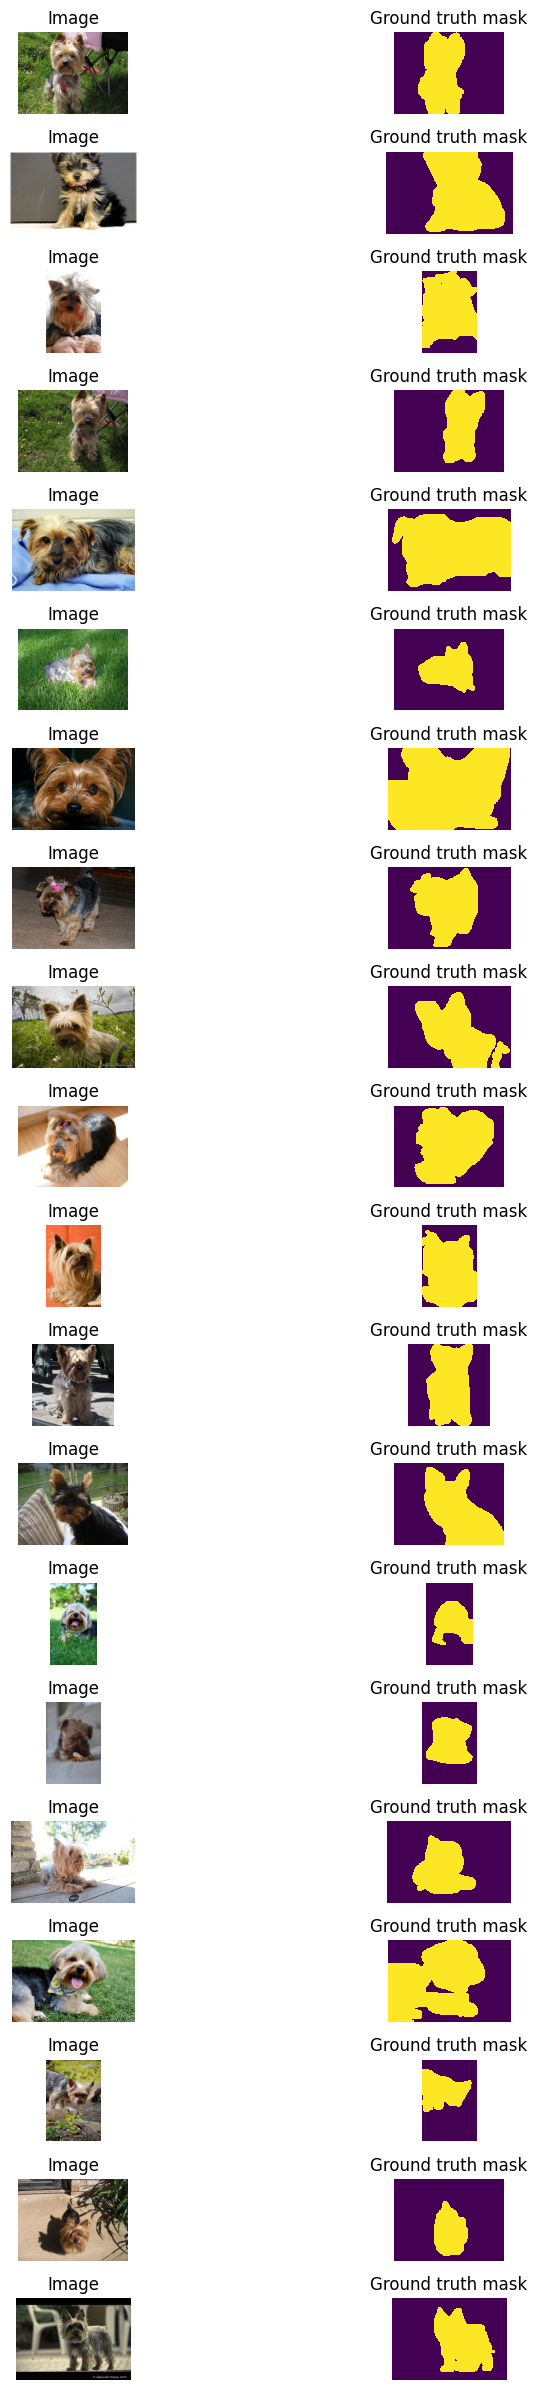

In [7]:
display_image_grid(test_images_filenames, images_directory, masks_directory)

#### Define a custom dataset class
Next, we define a PyTorch dataset. If you are new to PyTorch datasets, please refer to this tutorial - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.

\_\_init\_\_ will receive an optional transform argument. It is a transformation function of the Albumentations augmentation pipeline. Then in \_\_getitem\_\_, the Dataset class will use that function to augment an image and a mask and return their augmented versions.

In [40]:
from PIL import Image
from PIL import ImageFilter

import torchvision.transforms.functional as TF
from torchvision import transforms

class DataAugmentation:

    def __init__(
            self,
            img_size,
            with_random_hflip=False,
            with_random_vflip=False,
            random_color_tf=False
    ):
        self.img_size = img_size
        self.with_random_hflip = with_random_hflip
        self.with_random_vflip = with_random_vflip
        self.random_color_tf=random_color_tf
        
    def transform(self, imgs, labels, to_tensor=True):
        # resize image and covert to tensor
        imgs = [TF.to_pil_image(img) for img in imgs]
        labels = [TF.to_pil_image(img) for img in labels]
        
        imgs = [TF.resize(img, [self.img_size, self.img_size], interpolation=0)
                for img in imgs]
        labels = [TF.resize(img, [self.img_size, self.img_size], interpolation=0)
                for img in labels]

        if self.with_random_hflip and random.random() > 0.5:
            imgs = [TF.hflip(img) for img in imgs]
            labels = [TF.hflip(img) for img in labels]

        if self.with_random_vflip and random.random() > 0.5:
            imgs = [TF.vflip(img) for img in imgs]
            labels = [TF.vflip(img) for img in labels]


        if self.random_color_tf:
            color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3)
            imgs_tf = []
            for img in imgs:
                tf = transforms.ColorJitter(
                            color_jitter.brightness, 
                            color_jitter.contrast, 
                            color_jitter.saturation,
                            color_jitter.hue)
                imgs_tf.append(tf(img))
            imgs = imgs_tf
            
        if to_tensor:
            # to tensor
            imgs = [TF.to_tensor(img) for img in imgs]
            labels = [torch.from_numpy(np.array(img, np.uint8)).unsqueeze(dim=0)
                      for img in labels]
            
            imgs = [TF.normalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                    for img in imgs]

        return imgs, labels

In [41]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        
        # get image file name
        image_filename = self.images_filenames[idx]
        # read image using the image path and image_filename
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to RGB format
        # read mask using the mask path and image_filename
        mask = cv2.imread(os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED)
        mask = preprocess_mask(mask) # preprocess mask
        
        if self.transform is not None:
            [image], [mask] = self.transform.transform([image], [mask])
            
        return {'img': image, 'mask': mask}

Next, we create augmentation pipelines for the training and validation datasets. Note that we use A.Resize(256, 256) to resize input images and masks to the size 256x256 pixels.

In [42]:
train_transform = DataAugmentation(
                img_size=256,
                with_random_hflip=True,
                with_random_vflip=True,
                random_color_tf=True)

train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform)


test_transform = DataAugmentation(img_size=256)
test_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=test_transform)

Let's define a function that takes a dataset and visualizes different augmentations applied to the same image and the associated mask.

In [43]:
# create dataloader objects
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

#### Define the training loop

In [50]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            #print(batch)
            imgs, labels = batch['img'], batch['mask']
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, labels.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch['img'], batch['mask']#todo #get the img and mask 
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                loss = loss_fn(preds, labels.float())
                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

#### U-Net
We will use the UNet architecture for semantic segmentation. This architecture is very common for semantic segmentation. Skip connections at each convolution level helps network not to lose information about features from original input at this level. 
![UNet architecture.](https://miro.medium.com/v2/resize:fit:1400/1*jhYv-BI-dEQe85I7B4qjcQ.png)

In [51]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=2)

        self.enc_conv1 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.bottleneck_conv = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        
        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=384, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=192, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2) 
        self.dec_conv2 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=48, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        cat0 = self.bn0(self.act0(self.enc_conv0(x)))
        cat1 = self.bn1(self.act1(self.enc_conv1(e0)))
        cat2 = self.bn2(self.act2(self.enc_conv2(e1)))
        cat3 = self.bn3(self.act3(self.enc_conv3(e2)))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(torch.cat((self.upsample0(b), cat3), dim=1))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(torch.cat((self.upsample1(d0), cat2), dim=1))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(torch.cat((self.upsample2(d1), cat1), dim=1))))
        d3 = self.sigmoid(self.dec_conv3(torch.cat((self.upsample3(d2), cat0), dim=1)))
        return d3

In [52]:
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

In [53]:
# train the model
train(dataloaders, model, loss_fn, optimizer, epochs, device)

  0%|          | 0/10 [00:00<?, ?it/s]/home/saadeldine.eletter/.conda/envs/ugrip/lib/python3.10/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
100%|██████████| 10/10 [03:55<00:00, 23.51s/it, train loss:=0.626, test loss:=0.622]


In [54]:
def plotn(n, data, only_mask=False):
    in_images, preds, masks = data[0], data[1], data[2]
    fig, ax = plt.subplots(1, n)
    fig1, ax1 = plt.subplots(1, n)
    fig2, ax2 = plt.subplots(1, n)
    for i, (img, pred, mask) in enumerate(zip(in_images, preds, masks)):
        if i == n:
            break
        if not only_mask:
            ax[i].imshow(pred.permute((1, 2, 0)))
        else:
            ax[i].imshow(pred[0])
        ax1[i].imshow(mask[0])
        ax[i].axis('off')
        ax1[i].axis('off')
        ax2[i].imshow(img[0], cmap='gray')
        ax2[i].axis('off')
        ax2[i].axis('off')
    plt.show()

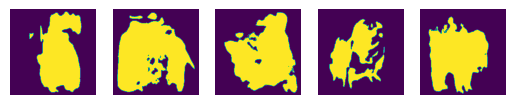

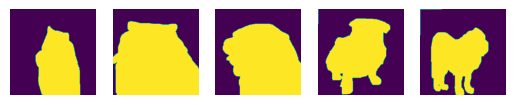

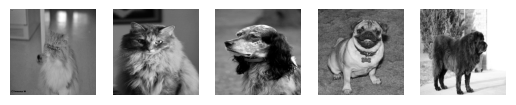

In [55]:
model.eval()
in_images = []
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, batch in enumerate(dataloaders[1]):
    if i == plots:
        break
    img = batch['img']
    mask = batch['mask'].squeeze(0)
    img = img.to(device)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
    img = img.detach().cpu()[0].float()
    in_images.append(img)
plotn(plots, (in_images, predictions, image_mask), only_mask=True)

#### References
1. https://microsoft.github.io/AI-For-Beginners/

2. https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/

3. https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/
